In [1]:
%matplotlib notebook
from utils.converter import *
import math
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('support-files/qubit.mplstyle')

FLUX = float
FLUX_NUMBER = int
cos = np.cos
sin = np.sin
pi = np.pi

fF = 10 ** (-15)
c = 10**(-10) #F/m Capacitance on interface
h = 6.64 * 10**(-34)
e = 1.6 * 10**(-19)
um = 10**(-6)
GHz = 10**(9)
ns = 10**(-9)
kOhm = 10**3
Rq = 6.484*kOhm
Delta = 3.1*10**(-23) # Superconducting delta
kb = 1.38 * 10**(-23)
Phi0 = h/(2 * e)
Gauss = 10**(-4) # Gauss to Wb/m²
kHz = 10**3
twoPi = 2*np.pi
MHz = 10**6

# Pipepline runthrough
- Take the signal on the SPA at each stage in order to see the signal and noise
- `-2dBm`
- `4.48GHz`
- `10ns`

$P^{max}_{coherent} = \frac{\hbar\omega_0}{8}\Gamma_1$ - all this power will be localised at the very strong middle peak

$P^{max}_{incoherent} = \frac{\hbar\omega_0}{2}\Gamma_1$ - all this power will be spread over a wide range of the order of $\Gamma_1$

And we can approximate $\Gamma_1/2\pi = 1/T_1 \rightarrow \Gamma_1 = 5MHz$

In [9]:
# Power from the photon source
w0 = 4.5 * GHz
T1 = 30 * ns
Gamma_1 = 1/T1 * 2 * pi

signal_coherent_1 = hbar * w0 / 8 * Gamma_1 
signal_coherent_1_dBm = W_to_dBm(signal_coherent_1)

signal_incoherent_1 = hbar * w0 / 2 * Gamma_1
signal_incoherent_1_dBm = W_to_dBm(signal_incoherent_1)

signal_coherent_1_dBm, signal_incoherent_1_dBm

(-139.04830648568245, -133.02770657240282)

In [10]:
# Quinstar ciculator @ 13mK
T = 13 / 1000
gain = 0

noise = 4 * kb * T
noise_dBm = W_to_dBm(noise)

signal_coherent_2_dBm = signal_coherent_1_dBm + gain
signal_incoherent_2_dBm = signal_incoherent_1_dBm + gain
noise_2_dBm = noise_dBm

signal_coherent_2_dBm, signal_incoherent_2_dBm, noise_2_dBm

(-139.04830648568245, -133.02770657240282, -211.44117569963964)

In [12]:
# Cryogenic amplifier @ 5K noise from datasheet
T = 5
gain = 37
CORRECTION = 0
noise_temp = 4 * kb * T

signal_coherent_3_dBm = signal_coherent_2_dBm + gain
signal_incoherent_3_dBm = signal_incoherent_2_dBm + gain

noise_3_dBm = W_to_dBm(
    (dBm_to_W(noise_2_dBm) + noise_temp) * 10**(gain/10)
) - CORRECTION

signal_coherent_3_dBm, signal_incoherent_3_dBm, noise_3_dBm

(-102.04830648568245, -96.02770657240282, -148.5796321765775)

<IPython.core.display.Javascript object>


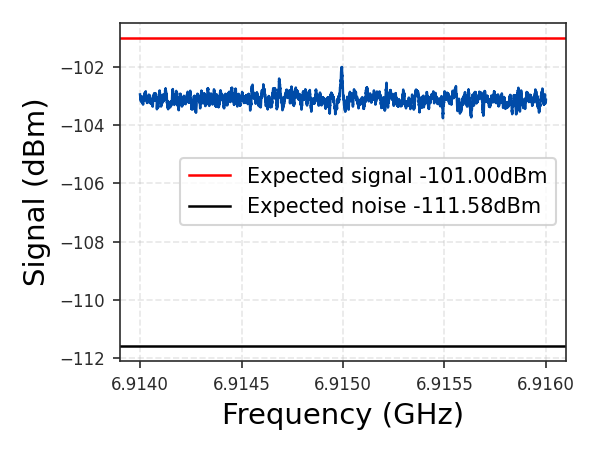

In [5]:
# Measurement - cannot measure noise due to resolution of SPA
RBW = 10*kHz
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage1.txt"

noise = W_to_dBm(dBm_to_W(noise_3_dBm) * RBW) 
signal = signal_3_dBm

with open(FILENAME) as fin:
    data = np.loadtxt(fin)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(signal, color="red", label=f"Expected signal {signal:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0], data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend()
plt.tight_layout()

In [107]:
# Amplifiers minicircuit
gain = 32
# Noise taken from calibration instead of temperature: jul-2021_-100dBm_spa_minicircuit
T = 295
noise_temp = W_to_dBm(4*kb*T)
noise_per_10kHz =-100
noise_calibration = W_to_dBm(dBm_to_W(noise_per_10kHz) / (10*kHz))
print(f"Calibrated noise: {noise}dBm/Hz, temperature noise: {noise_temp}dBm/Hz")

signal_4_dBm = signal_3_dBm + gain
noise_4_dBm = W_to_dBm(
    (dBm_to_W(noise_3_dBm)) * 10**(gain/10) + dBm_to_W(noise_calibration)
)

signal_4_dBm, noise_4_dBm

Calibrated noise: -111.57963217657749dBm/Hz, temperature noise: -167.88238906292636dBm/Hz


(-69.36132702588861, -119.54038722444542)

<IPython.core.display.Javascript object>


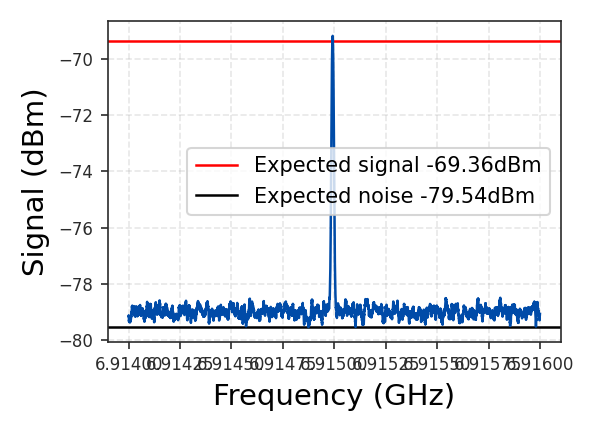

(-69.36132702588861, -79.54038722444542)

In [108]:
# Measurement
RBW = 10*kHz
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage2.txt"

noise = W_to_dBm(dBm_to_W(noise_4_dBm) * RBW) 
signal = signal_4_dBm

with open(FILENAME) as fin:
    data = np.loadtxt(fin)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(signal, color="red", label=f"Expected signal {signal:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0], data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend()
plt.tight_layout()

signal, noise

In [153]:
# Amplifiers a0X (we will also add a second one)
gain = 27
# Noise taken from calibration instead of temperature: spa-single-a0x
T = 295
noise_temp = W_to_dBm(4*kb*T)
noise_per_10kHz =-100
noise_calibration = W_to_dBm(dBm_to_W(noise_per_10kHz) / (10*kHz))
print(f"Calibrated noise: {noise}dBm/Hz, temperature noise: {noise_temp}dBm/Hz")

signal_5_dBm = signal_4_dBm + gain
noise_5_dBm = W_to_dBm(
    (dBm_to_W(noise_4_dBm)) * 10**(gain/10) + dBm_to_W(noise_calibration)
)

signal_5_dBm, noise_5_dBm

Calibrated noise: -53.54028909075595dBm/Hz, temperature noise: -167.88238906292636dBm/Hz


(-42.36132702588861, -92.54030927390396)

<IPython.core.display.Javascript object>


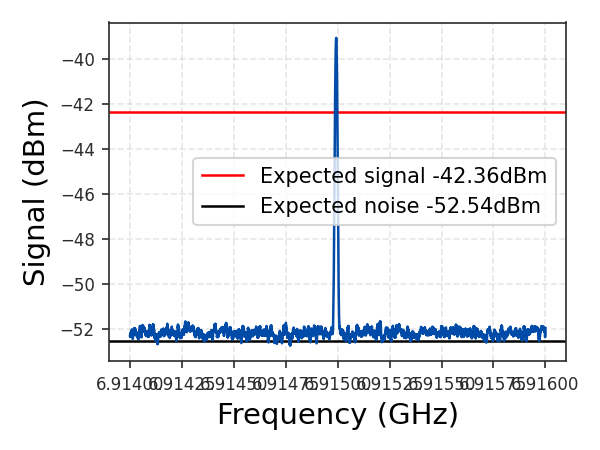

In [154]:
# Measurement
RBW = 10*kHz
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage3.txt"

noise = W_to_dBm(dBm_to_W(noise_5_dBm) * RBW) 
signal = signal_5_dBm

with open(FILENAME) as fin:
    data = np.loadtxt(fin)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(signal, color="red", label=f"Expected signal {signal:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0], data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend()
plt.tight_layout()

Therefore noise is expected to be
- In W: 94dBm-in-watts * RBW-in-Hz
- In dBm: $-93 + 10 * log_{10}(\Delta{f})$ dBm

Next we perform downconversion of the signal. 
- Signal @ 6.915GHz
- Mix with generator @ 6.9151 GHZ (100kHz offset)
- 13 dBm refference signal

From graph we can see that signal is succesfully downconverted, with and amplitude loss of 15dBm

<IPython.core.display.Javascript object>


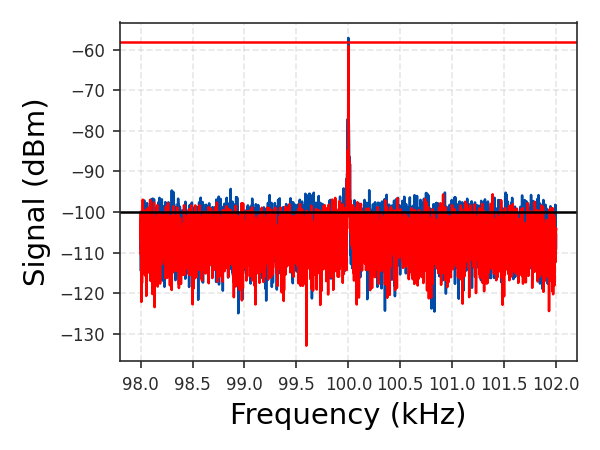

In [133]:
fix, ax = plt.subplots(1, 1, figsize=(4, 3))

signal_6_dBm=-58
noise_6_dBm=-100

FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage4-I.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin)
ax.plot(data[:, 0], data[:, 1])

FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage4-Q.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin)
ax.plot(data[:, 0], data[:, 1], color="red")

ax.axhline(signal_6_dBm, color="red", label=f"Expected signal {signal:.2f}dBm")
ax.axhline(noise_6_dBm, color="black", label=f"Expected noise {noise:.2f}dBm")

ax.set_xlabel("Frequency (kHz)")
ax.set_ylabel("Signal (dBm)")
plt.tight_layout()

In [141]:
# Next we apply a DC amplifier with low noise
# In the same measurement we add the filters, which should not affect the signal at 100kHz
gain = 22

signal_7_dBm = signal_6_dBm + gain
noise_7_dBm = W_to_dBm(
    (dBm_to_W(noise_6_dBm)) * 10**(gain/10)
)
signal_7_dBm, noise_7_dBm

(-36, -78.0)

<IPython.core.display.Javascript object>


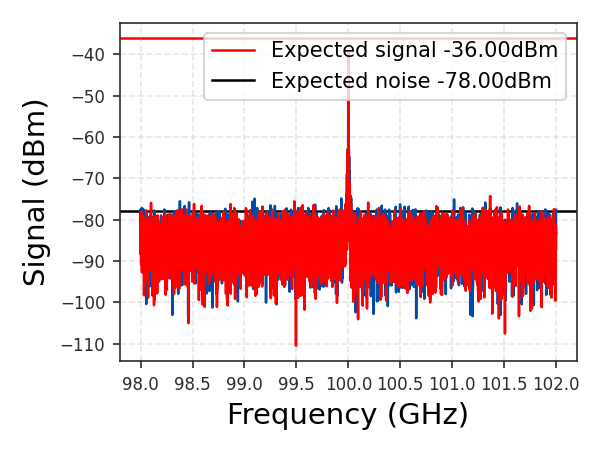

In [140]:
# Measurement
RBW = 1

noise = W_to_dBm(dBm_to_W(noise_7_dBm) * RBW) 
signal = signal_7_dBm
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(signal, color="red", label=f"Expected signal {signal:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")

FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage5-Q-A.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin)
ax.plot(data[:, 0], data[:, 1])

FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_42_tracking-signal_stage6-Q-A-filter98.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin)
ax.plot(data[:, 0], data[:, 1], color="red")

ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend()
plt.tight_layout()

In [157]:
dBm_to_V(-35) / 1.1

0.00511219386536681

In [144]:
# Finally at the digitiser, we are measuring the signal. The amount of codes the signal corresponds to is
voltage = dBm_to_V(-36)
precision = 2.2 / (2**14)

voltage / precision

37.32478016249649